In [25]:
from collections import defaultdict

import json

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker

import numpy as np

import openturns as ot
import openturns.viewer as viewer
import openturns.viewer as otv

import pickle

plt.rcParams['figure.dpi']= 500
plt.rcParams['text.usetex'] = True

# Importing data

In [14]:
labels = [
    r"$\alpha$",
    r"$\beta$",
    r"$\epsilon_e$",
    r"$\epsilon_c$",
    r"$d_p$",
    r"$\Gamma_{p}(0)$",
    r"$a_v$"
]

In [15]:
# Time indices in days
t = np.load('../../data/SG_time.npy')

In [16]:
# Parameters of the Steam Generator
input_dic = {}
input_dic['SG'] = json.load(open('../../data/SG_cleaning_conditioning.json'))

In [50]:
# Color scheme for chemical conditioning
colors_n = {'C1': {'low': 'lightgreen', 'high': 'forestgreen'},
            'C2': {'high': 'slateblue'}}
colors_ch = {'C1': {'low': ['lightgreen', 0.05], 'high': ['forestgreen', 0.2]},
             'C2': {'high':['slateblue',  0.2]}}

In [18]:
# PCE metamodel
with open('../../data/PCE_metamodel.pkl', "rb") as f:
    unpickler = pickle.Unpickler(f)
    pce = unpickler.load()

# Sobol' indices

In [52]:
pce_sobol = ot.FunctionalChaosSobolIndices(pce) 

In [53]:
sobol_first_order, sobol_total = [], []
for i in range(len(labels)):
    sobol_i_f, sobol_i_t = [], []
    for j in range(75):
        sobol_i_f.append(pce_sobol.getSobolIndex(i, j))
        sobol_i_t.append(pce_sobol.getSobolTotalIndex(i, j))
    sobol_first_order.append(sobol_i_f)
    sobol_total.append(sobol_i_t)
sobol_first_order, sobol_total = np.asarray(sobol_first_order), np.asarray(sobol_total)

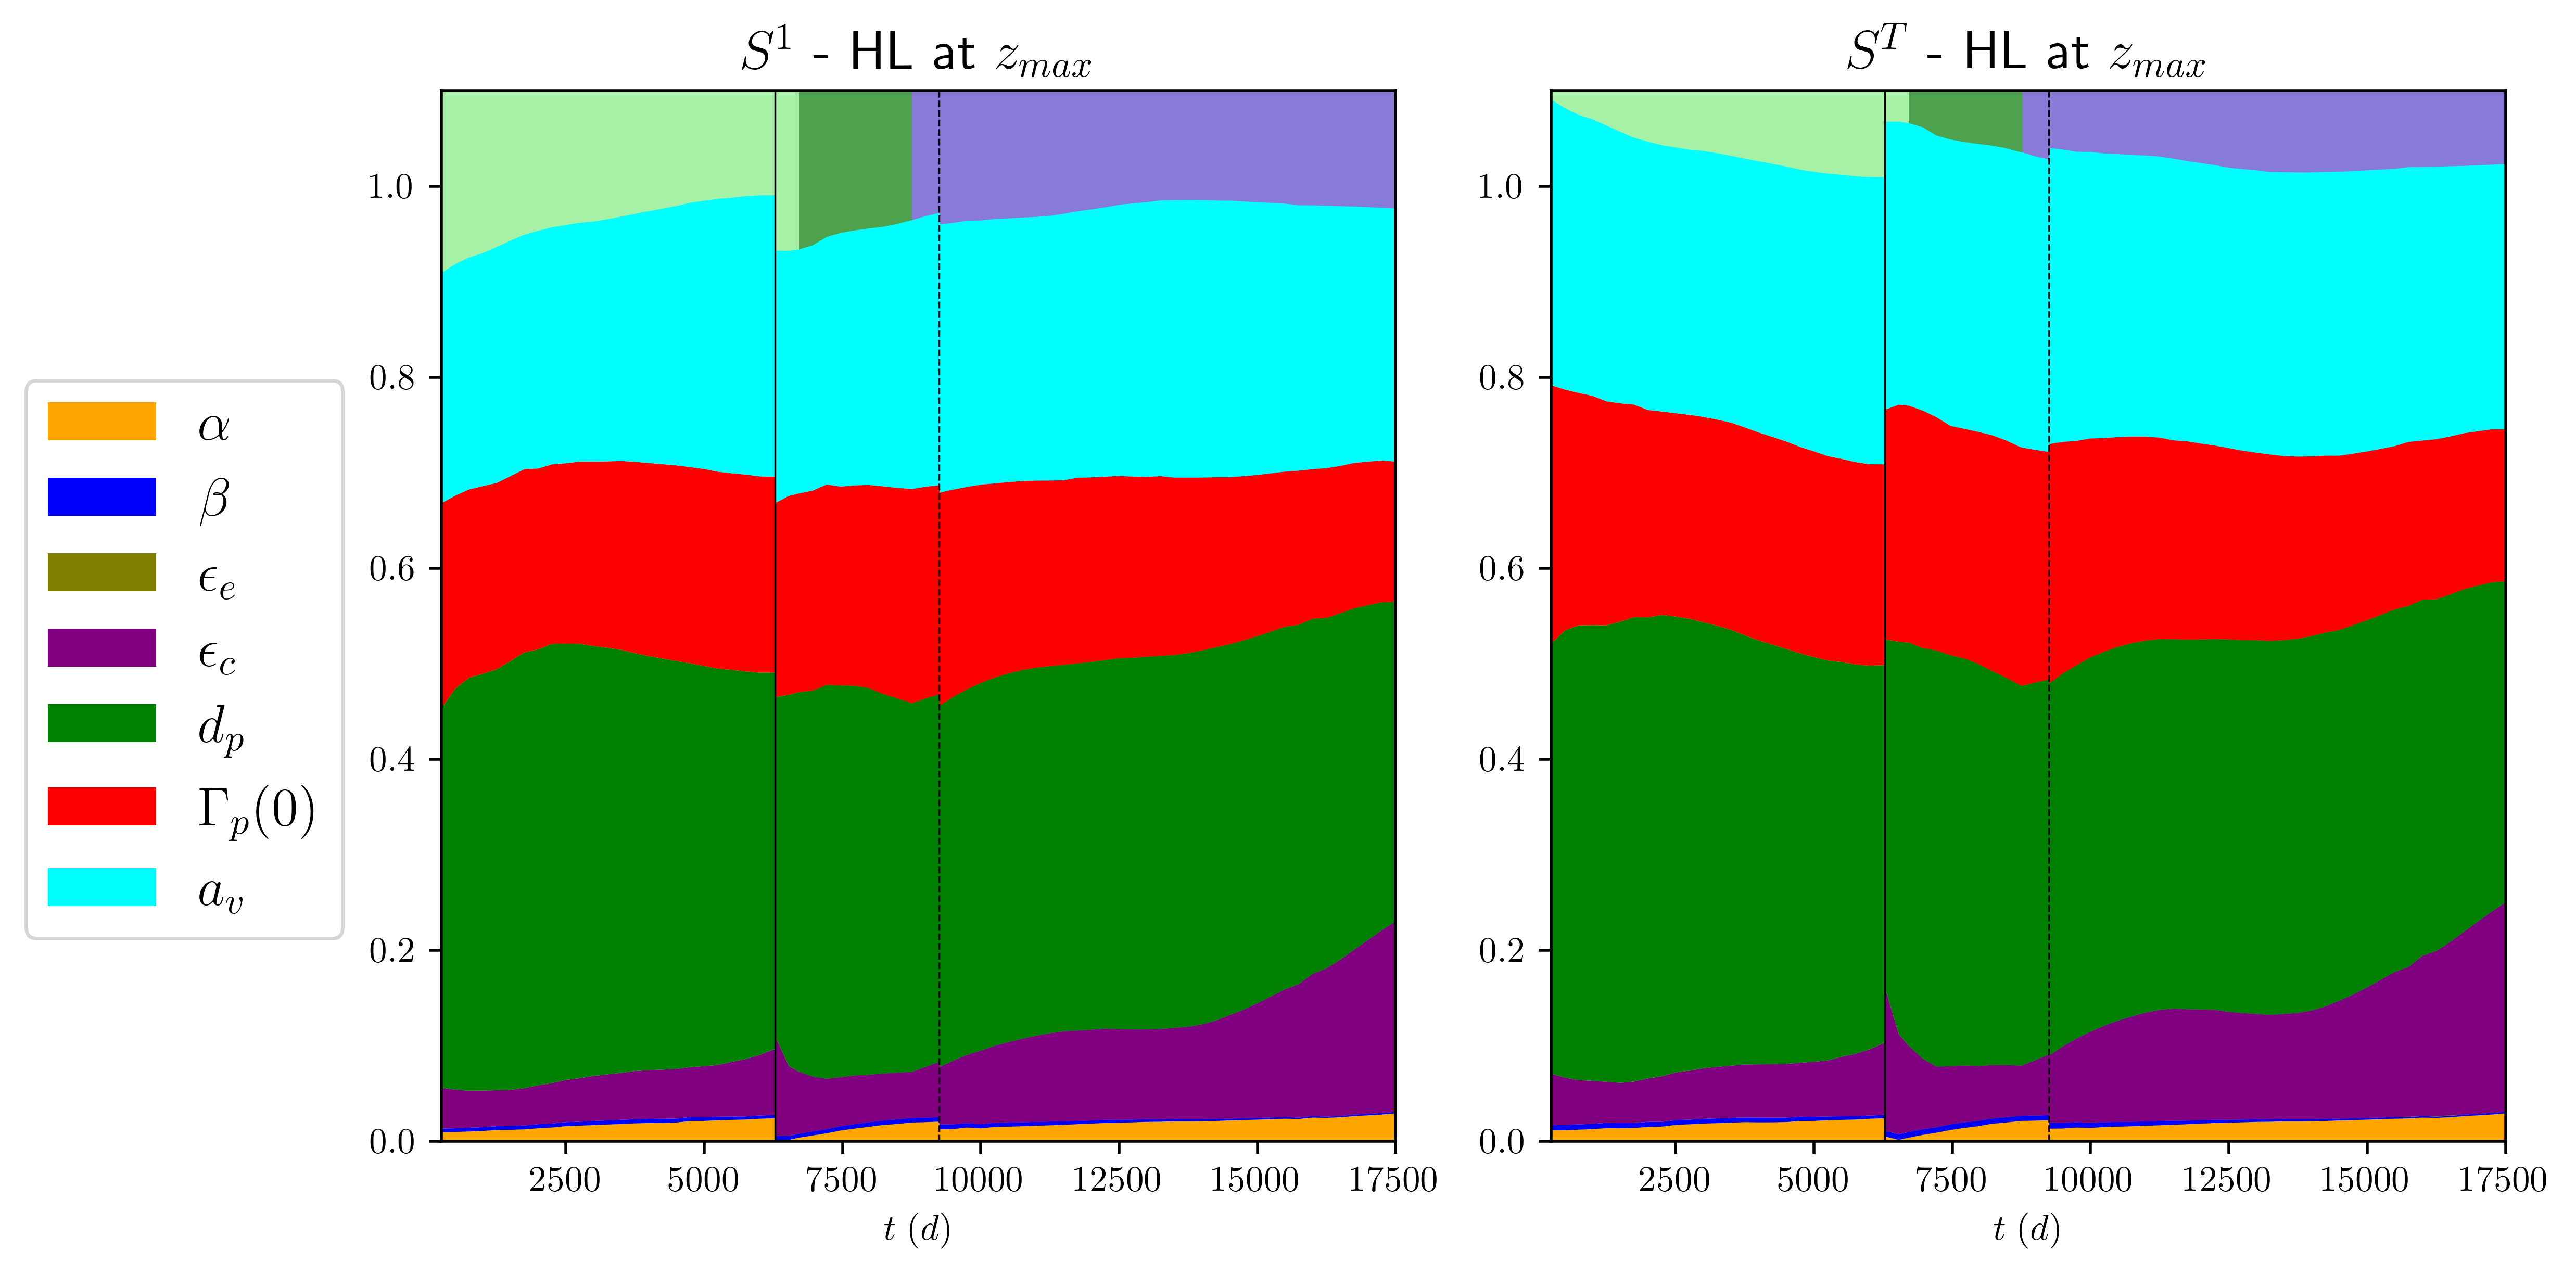

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), layout='tight')
colors = ['orange', 'blue', 'olive','purple', 'green', 'red','cyan']

cond = input_dic['SG']['chimie']['conditionnementSecondaire']
for k in range(len(cond)):
    if k == len(cond)-1:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, max(t)
    else:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, cond[k+1]['nbHeuresExploit']/24
    c = cond[k]
    typ = colors_n[c['type']]
    col = typ[str(c['ph'])]
    axs[0].axvspan(t_i, t_f, facecolor=col, alpha = 0.8)
    axs[1].axvspan(t_i, t_f, facecolor=col, alpha = 0.8)

axs[0].stackplot(t, sobol_first_order, labels=labels, colors=colors)
axs[0].set_xlim(250,17500)
axs[0].set_ylim(0,1.1)
axs[0].set_xlabel(r'$t\;(d)$')
axs[0].set_title(r'$S^{1}$ - HL at $z_{max}$', fontsize=15)

axs[1].stackplot(t, sobol_total, labels=labels, colors=colors)
axs[1].set_xlim(250,17500)
axs[1].set_ylim(0,1.1)
axs[1].set_xlabel(r'$t\;(d)$')
axs[1].set_title(r'$S^{T}$ - HL at $z_{max}$',  fontsize=15)

axs[0].legend(bbox_to_anchor=(-0.075,0.75), fontsize=15)

nett = input_dic['SG']['chimie']['nettoyage']
for k in range(len(nett)):
    if nett[k]['type'] == 'curatif':
        axs[0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        axs[1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        
    elif nett[k]['type'] == 'preventif':
        axs[0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)
        axs[1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)


fig.savefig('../../plots/Sobol\'/PCE_S_1_T.pdf', format='pdf', bbox_inches='tight')
fig.savefig('../../plots/Sobol\'/PCE_S_1_T.png', format='png', bbox_inches='tight')

# Variance plot

In [113]:
def ComputeGroupLabelsFromLabelNames(variableNamesList, groupsList):
    """
    Compute the labels of groups from names

    Parameters
    ----------
    variableNamesList : list(str)
        The list of variables names.

    groupsList: list(list(int))
        Each item in the list is a list of indices of variables
        representing a group.
        The number of items in the list is the number of
        groups.

    Returns
    -------
    group_labels : list(str)
        The labels of the groups of variables.

    Example
    -------
    >>> variableNamesList = ["A", "B", "C"]
    >>> groupsList = [[0], [1], [2], [0, 1], [0, 2]]
    >>> group_labels = ComputeGroupLabelsFromLabelNames(variableNamesList, groupsList)
    >>> group_labels
    ["A", "B", "C", "AB", "AC"]
    """
    number_of_keys = len(variableNamesList)
    group_labels = []
    for i in range(len(groupsList)):
        group = groupsList[i]
        for j in group:
            if j < 0 or j >= number_of_keys:
                raise ValueError(
                    f"index = {j} inconsistent with the number of keys {number_of_keys}"
                )
        label_list = [variableNamesList[j] for j in group]
        label = "[" + ",".join(label_list) + "]"
        group_labels.append(label)
    return group_labels

In [260]:
def ComputeInteractionSobolIndices(polynomialChaosResult):
    """
    Compute Sobol' interaction indices of a PCE

    Parameters
    ----------
    polynomialChaosResult : ot.FunctionalChaosResult
        The polynomial chaos expansion.

    Returns
    -------
    interaction_sobol_indices : ot.Sample(number_of_groups, outputDimension)
        The interaction Sobol' indices.

    group_list : list(list(int))
        The list of groups of variables.
        Each group of variables is a list of indices representing
        the index of each variable in the group.
    """
    outputSample = polynomialChaosResult.getOutputSample()
    outputDimension = outputSample.getDimension()

    # Get the part of variance of each multi-index
    functionalChaosSobolIndices = ot.FunctionalChaosSobolIndices(polynomialChaosResult)
    input_dimension = polynomialChaosResult.getInputSample().getDimension()
    indices = polynomialChaosResult.getIndices()
    number_of_coefficients = len(indices)

    # Compute the part of variance of each coefficient
    part_of_variances_by_coefficient = ot.Sample(number_of_coefficients, outputDimension)
    for marginalIndex in range(outputDimension):
        part_of_variance_point = functionalChaosSobolIndices.getPartOfVariance(marginalIndex)
        part_of_variances_by_coefficient[:, marginalIndex] = ot.Sample.BuildFromPoint(part_of_variance_point)

    # Gather each multi-indice into groups of variables
    # Each key of the dictionnary represent the group of variables.
    # Each corresponding value is the list of multi-indices in that group.
    orthogonalBasis = polynomialChaosResult.getOrthogonalBasis()
    enumerateFunction = orthogonalBasis.getEnumerateFunction()
    group_dictionnary = defaultdict(list)
    for i in range(number_of_coefficients):
        multi_indices = enumerateFunction(indices[i])
        if sum(multi_indices) > 0:
            # Compute the group of input active variable of each multi-index
            group_of_variables = [j for j in range(input_dimension) if multi_indices[j] > 0]
            group_of_variables = tuple(group_of_variables)
            group_dictionnary[group_of_variables].append(i)

    """
    group_dictionnary
    defaultdict(list,
                {(0,): [1, 7],
                (1,): [2],
                (3,): [3, 8, 12, 28],
                (4,): [4, 9, 13, 29],
                (5,): [5, 10, 14],
                (6,): [6, 11, 15, 30],
                (0, 4): [16],
                (0, 5): [17],
                (0, 6): [18],
                (1, 4): [19],
                (1, 6): [20],
                (2, 5): [21],
                (3, 4): [22],
                (3, 5): [23],
                (3, 6): [24],
                (4, 5): [25],
                (4, 6): [26],
                (5, 6): [27]})
    """

    # Get the list of (unique) groups of variables
    group_list = sorted(group_dictionnary)
    number_of_groups = len(group_list)

    # Gather the interaction Sobol' indices time series
    interaction_sobol_indices = ot.Sample(number_of_groups, outputDimension)
    for i in range(number_of_groups):
        group = group_list[i]
        multi_indices_list = group_dictionnary[group]
        for coefficient_index in multi_indices_list:
            interaction_sobol_indices[i,:] += part_of_variances_by_coefficient[coefficient_index,:]
    return interaction_sobol_indices, group_list


In [261]:
inputDistribution = pce.getDistribution()
inputDescription = inputDistribution.getDescription()

In [262]:
# %% Gather intermediate data
inputSample = pce.getInputSample()
sampleSize = inputSample.getSize()
inputDimension = inputSample.getDimension()
outputSample = pce.getOutputSample()
outputDimension = outputSample.getDimension()
print("Sample size = ", sampleSize)
print("Input dimension = ", inputDimension)
print("Output dimension =", outputDimension)

Sample size =  750
Input dimension =  7
Output dimension = 75


In [263]:
# Get the part of variance of each multi-index
functionalChaosSobolIndices = ot.FunctionalChaosSobolIndices(pce)
input_dimension = pce.getInputSample().getDimension()
indices = pce.getIndices()
number_of_coefficients = len(indices)
print("Number of coefficients = ", number_of_coefficients)

# %%
# Compute the part of variance of each coefficient
interaction_sobol_indices, group_list = ComputeInteractionSobolIndices(pce)
number_of_groups = len(group_list)
print("Number of groups = ", number_of_groups)

Number of coefficients =  31
Number of groups =  18


In [264]:
sensitivity_threshold=0
group_list_threshold = []
interaction_sobol_indices_threshold = ot.Sample(0, outputDimension)
for group_index in range(number_of_groups):
    if interaction_sobol_indices[group_index,:].normInf() > sensitivity_threshold:
        group_list_threshold.append(group_list[group_index])
        interaction_sobol_indices_threshold.add(interaction_sobol_indices[group_index])


In [265]:
group_labels_with_description_threshold = ComputeGroupLabelsFromLabelNames(
    inputDescription, group_list_threshold
)

In [267]:
interaction_sensitivity_remainder = 1.0 - np.sum(interaction_sobol_indices_threshold, axis = 0)
interaction_sobol_indices_threshold.add(interaction_sensitivity_remainder)
number_of_groups_threshold = len(interaction_sobol_indices_threshold)

group_labels_with_description_threshold.append("*")
number_of_groups_threshold = len(interaction_sobol_indices_threshold)
print("Number of thresholded groups = ", number_of_groups_threshold)

Number of thresholded groups =  19


In [268]:
pceRandomVector = ot.FunctionalChaosRandomVector(pce)
pceCovariance = pceRandomVector.getCovariance()
pceVariance = [pceCovariance[i, i] for i in range(outputDimension)]


In [269]:
cumulated_variances = ot.Sample(1, outputDimension)
cumulated_variances.add(np.cumsum(interaction_sobol_indices_threshold, axis=0))

In [270]:
pceVariance = np.asarray(pceVariance)
cumulated_variances = np.asarray(cumulated_variances)

In [271]:
variance_output = []
for group_index in range(number_of_groups_threshold):
    var = [pceVariance[k] * (cumulated_variances[1 + group_index, k] - cumulated_variances[group_index, k]) for k in range(outputDimension)]
    variance_output.append(var)
variance_output = np.asarray(variance_output)

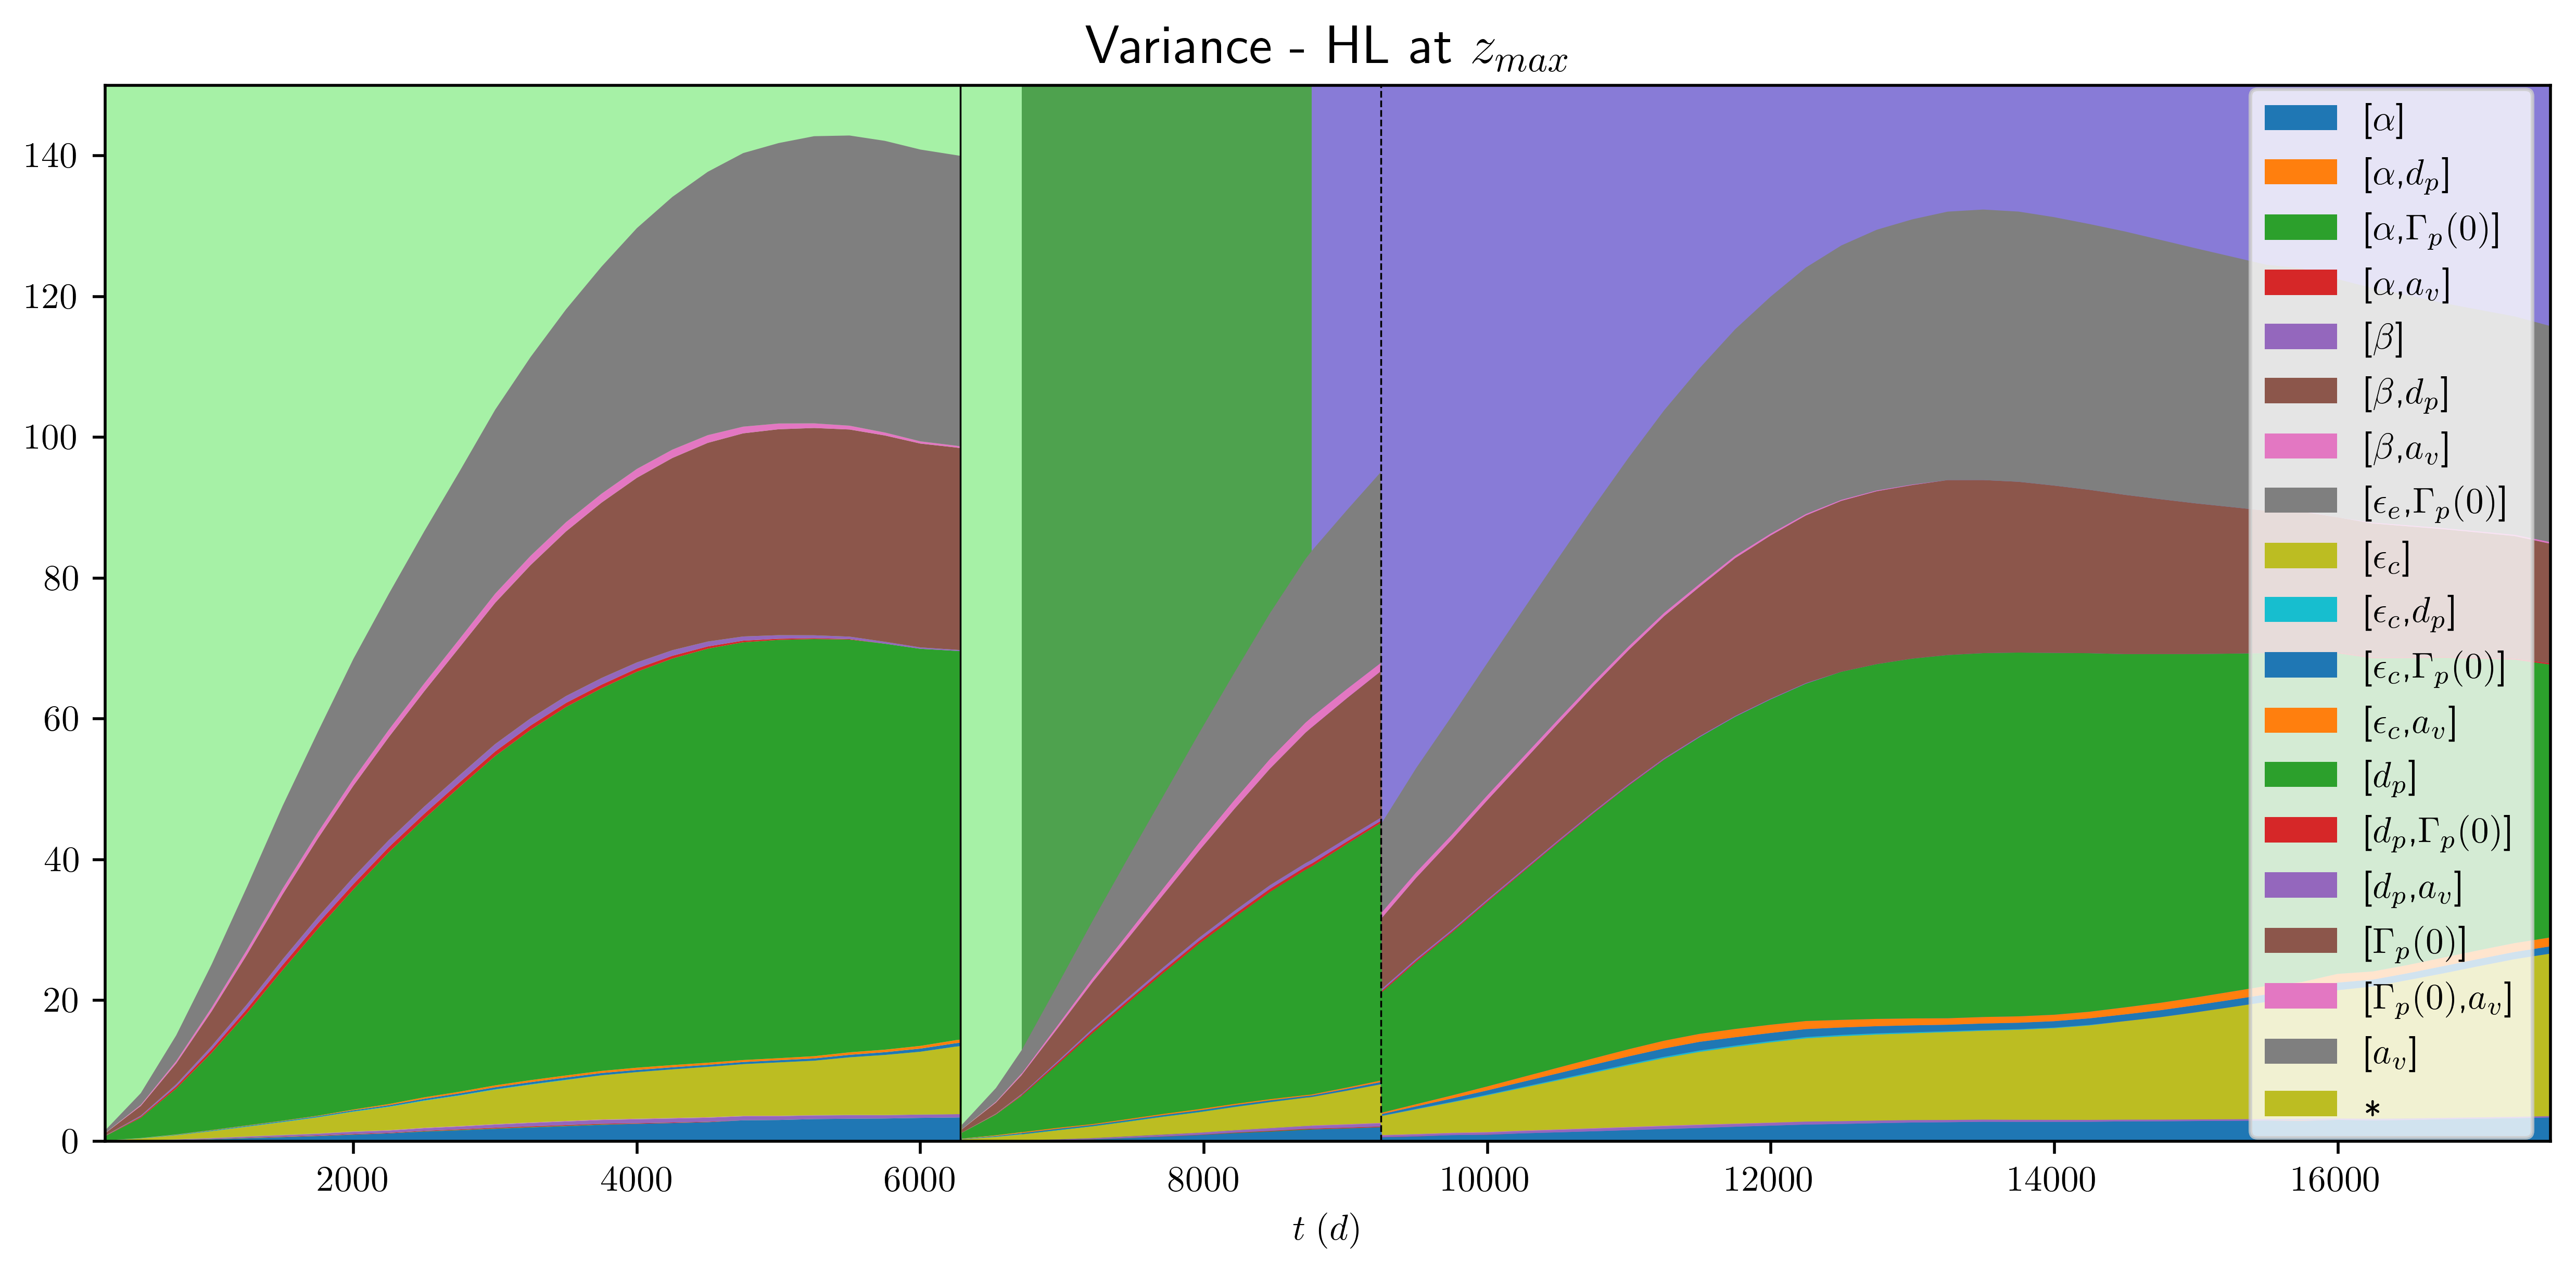

In [273]:
fig, axs = plt.subplots(1, 1, figsize=(10,5), layout='tight')
#colors = ['purple', 'green', 'red', 'cyan','yellow']

cond = input_dic['SG']['chimie']['conditionnementSecondaire']
for k in range(len(cond)):
    if k == len(cond)-1:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, max(t)
    else:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, cond[k+1]['nbHeuresExploit']/24
    c = cond[k]
    typ = colors_n[c['type']]
    col = typ[str(c['ph'])]
    axs.axvspan(t_i, t_f, facecolor=col, alpha = 0.8)

axs.stackplot(t, variance_output, labels=group_labels_with_description_threshold)#, labels=labels, colors=colors)
axs.set_xlim(250,17500)
axs.set_xlabel(r'$t\;(d)$')
axs.set_title(r'Variance - HL at $z_{max}$', fontsize=15)

axs.legend()

nett = input_dic['SG']['chimie']['nettoyage']
for k in range(len(nett)):
    if nett[k]['type'] == 'curatif':
        axs.axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        
    elif nett[k]['type'] == 'preventif':
        axs.axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)

In [283]:
select = [0, 4, 5, 8, 12, 15, 17, 18]
output = []
for k in select:
    if k==5:
        output.append([0.0]*len(t))
    else:
        output.append(variance_output[k,:])
output = np.asarray(output)

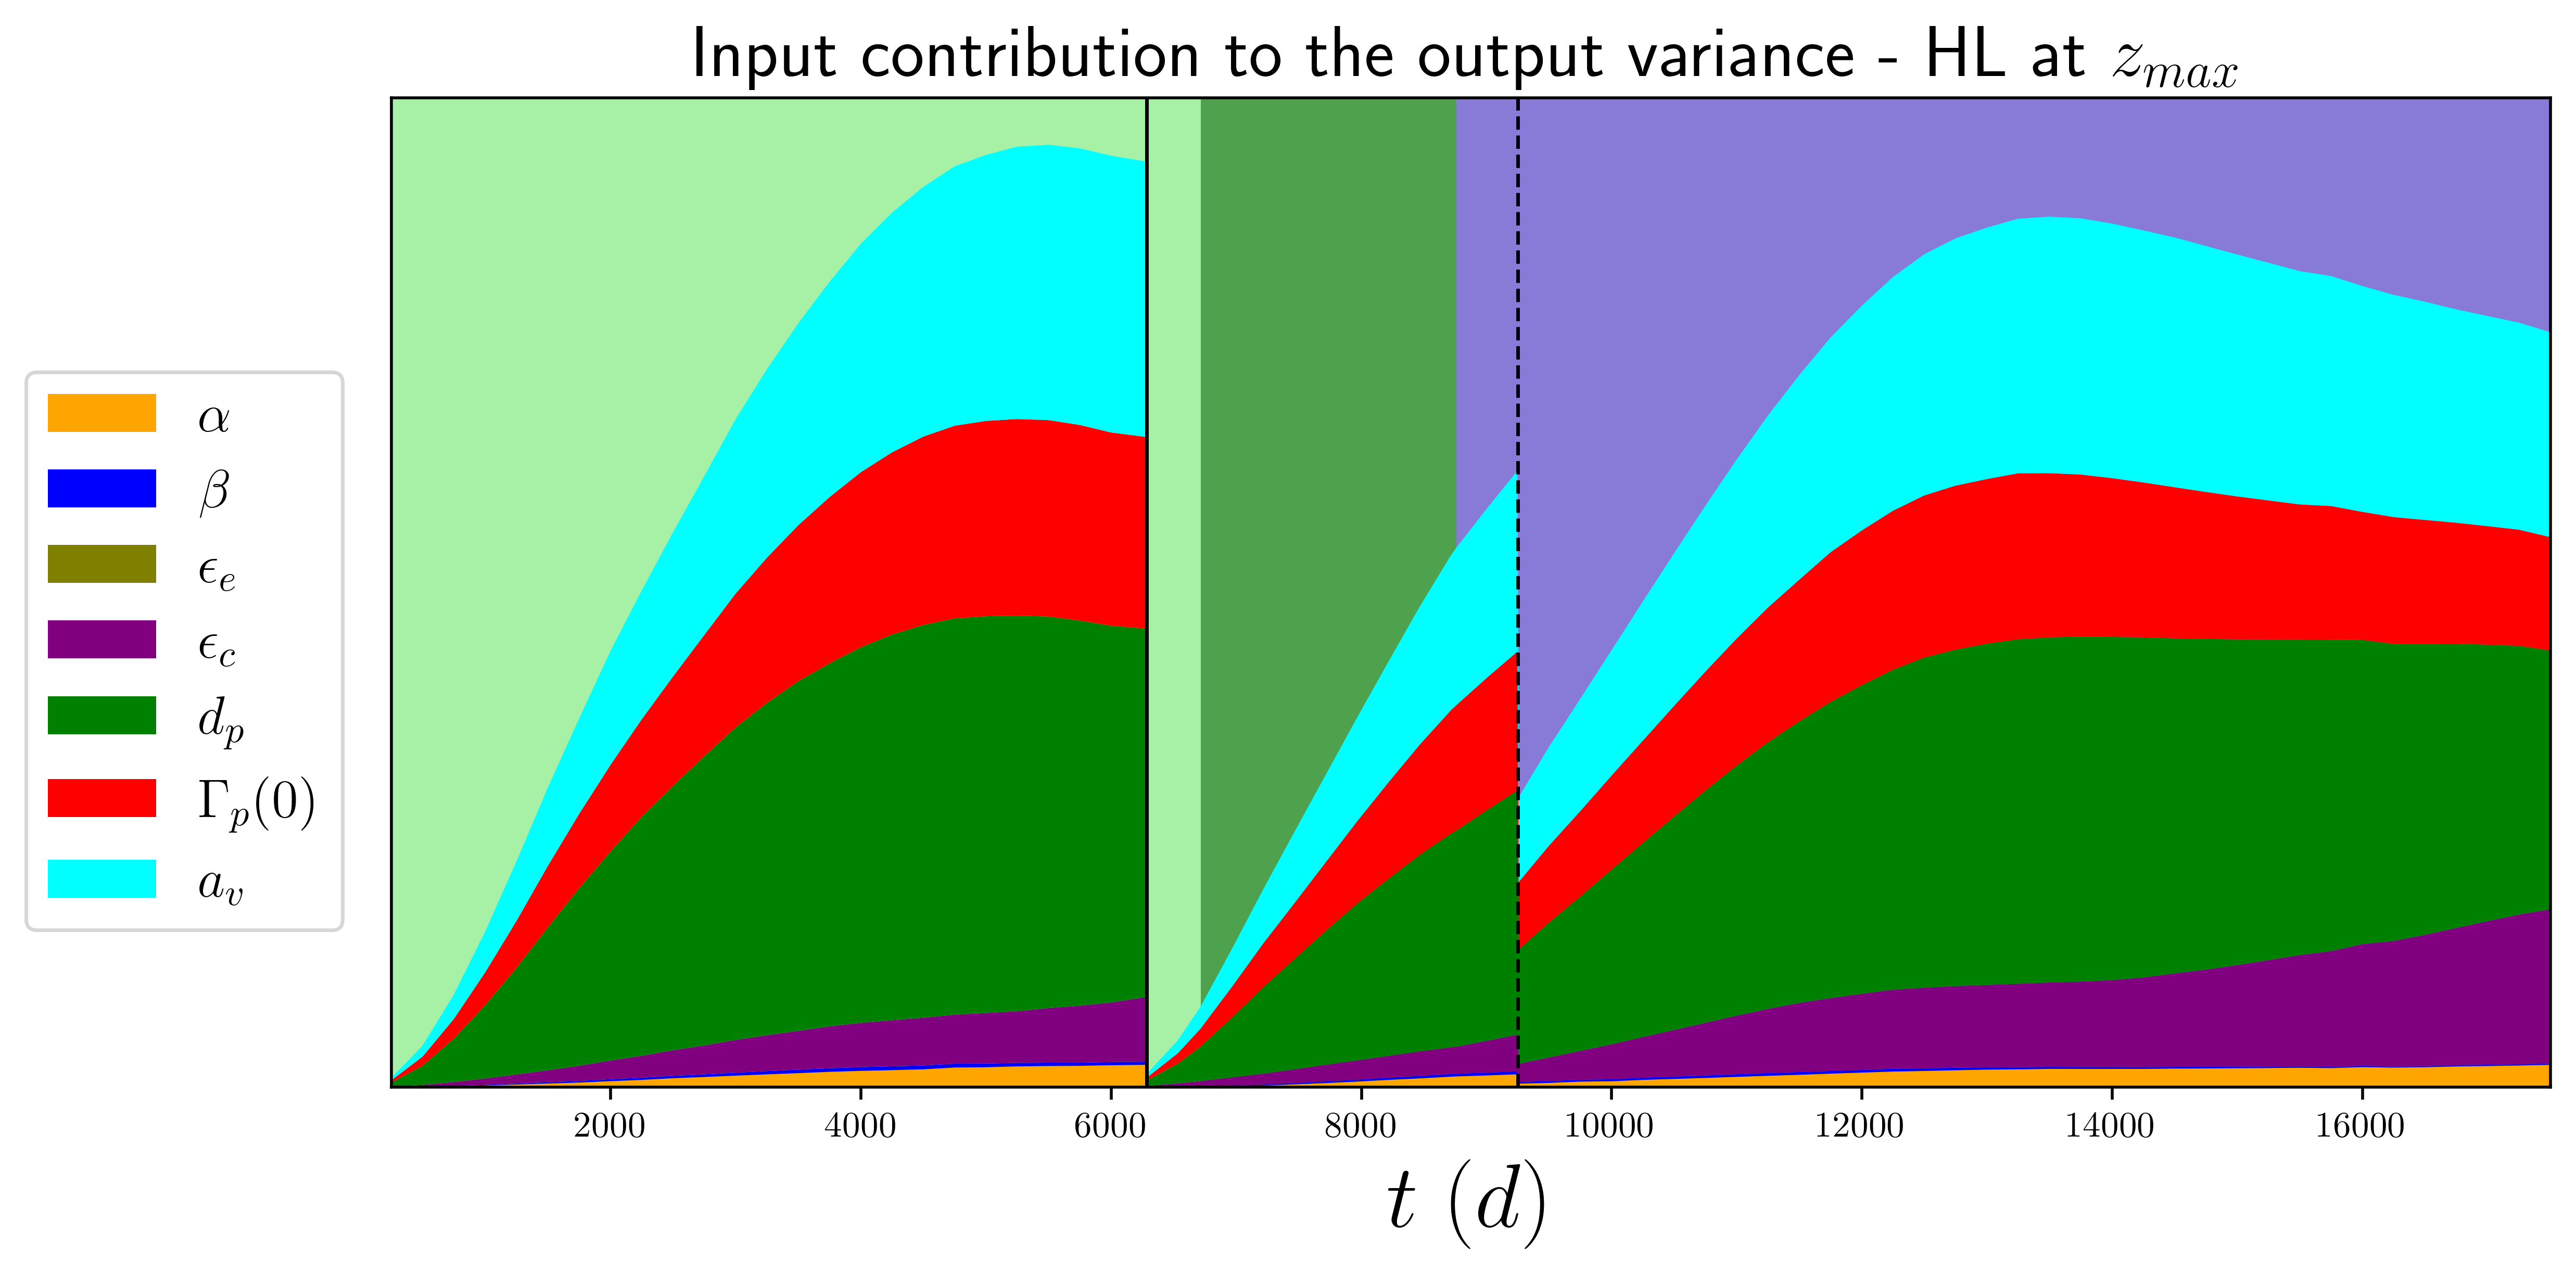

In [304]:
fig, axs = plt.subplots(1, 1, figsize=(10,5), layout='tight')
colors = ['orange', 'blue', 'olive','purple', 'green', 'red','cyan', 'yellow']

cond = input_dic['SG']['chimie']['conditionnementSecondaire']
for k in range(len(cond)):
    if k == len(cond)-1:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, max(t)
    else:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, cond[k+1]['nbHeuresExploit']/24
    c = cond[k]
    typ = colors_n[c['type']]
    col = typ[str(c['ph'])]
    axs.axvspan(t_i, t_f, facecolor=col, alpha = 0.8)

axs.stackplot(t, output, labels=labels, colors=colors, zorder=2)
axs.set_xlim(250,17500)
axs.set_yticks([])
axs.set_xlabel(r'$t\;(d)$', fontsize=25)
axs.set_title(r'Input contribution to the output variance - HL at $z_{max}$', fontsize=20)

axs.legend(bbox_to_anchor=(-0.01,0.75), fontsize=15)

nett = input_dic['SG']['chimie']['nettoyage']
for k in range(len(nett)):
    if nett[k]['type'] == 'curatif':
        axs.axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=1.0)
        
    elif nett[k]['type'] == 'preventif':
        axs.axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=1.0)

fig.savefig('../../plots/Sobol\'/variance_output.pdf', format='pdf', bbox_inches='tight')
fig.savefig('../../plots/Sobol\'/variance_output.png', format='png', bbox_inches='tight')
